MDS
---
Multidimensional Scaling
* Replication of 2020 article https://link.springer.com/article/10.1007/s42113-020-00073-z (https://osf.io/efjmq)
    * Rocks dataset was created in 2017 here: https://link.springer.com/article/10.3758/s13428-017-0884-8 (https://osf.io/w64fv)
    * Further work in Sanders' 2018 doctoral thesis https://scholarworks.iu.edu/dspace/handle/2022/22415 (https://osf.io/d6b9y)
        * includes the relevant additional data such as the 360 rocks images set
* Dataset: 120 Rock Images
* We have a ready prepared file with MDS coordinates
* And we have similarity judgements from which we could compute these MDS coordinates on our own

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from glob import glob
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


rock_images_glob = "120 Rock Images/*.png"
rock_images = glob(rock_images_glob)
rock_images.sort() # get them in the right order

judgements_glob = "Similarity Judgments Data/rocks_similarity_120_*.txt"
judgements_files = glob(judgements_glob)

mds_file = "MDS/mds_120_supplemental_dims.txt"

### Plot functions

In [3]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    """
    Creates scatter with image file
    """
    
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists


def imjitter(x, y, image, ax=None, zoom=1):
    """
    Creates scatter with image file
    """
    
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        y0 += np.random.uniform(-.2, .2)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists


#def plot_dims(dim_a, dim_b, mds_obs, rock_images):
#    """
#    Plots rocks for given dimensions
#    """
#    plt.figure(figsize = (6, 6))
#    for i, rock in enumerate(rock_images):
#        imscatter(mds_obs[i, dim_a-1], mds_obs[i, dim_b-1], rock, zoom = 0.033)
#    plt.xlabel(f"MDS Dimension {dim_a}")
#    plt.ylabel(f"MDS Dimension {dim_b}")
#    
#    return None


def plot_compare_dims(dim_a, dim_b, mds_obs, mds_obs_2, rock_images):
    """
    Plots rocks for given dimensions
    """
    fig = plt.figure(figsize = (12, 6))

    # plot 1
    ax_1 = plt.subplot(1, 2, 1)
    for i, rock in enumerate(rock_images):
        imscatter(mds_obs[i, dim_a-1], mds_obs[i, dim_b-1], rock, zoom = 0.033, ax=ax_1)
    ax_1.set_xlabel(f"MDS Dimension {dim_a}")
    ax_1.set_ylabel(f"MDS Dimension {dim_b}")
    ax_1.set_title("MDS coordinates Sanders & Nosofsky (2020)")

    # plot 2
    ax_2 = plt.subplot(1, 2, 2)
    for i, rock in enumerate(rock_images):
        imscatter(mds_obs_2[i, dim_a-1], mds_obs_2[i, dim_b-1], rock, zoom = 0.033, ax=ax_2)
    ax_2.set_xlabel(f"MDS Dimension {dim_a}")
    ax_2.set_title("MDS coordinates replication")
    
    plt.tight_layout()
    
    return None


#def plot_predictions(dim, mds_obs, cnn_pred, rock_images):
#    """
#    Plots rocks observed vs predicted values
#    """
#    
#    r = np.corrcoef(cnn_pred[:, dim-1], mds_obs[:, dim-1]).min()
#
#    plt.figure(figsize = (6, 6))
#    for i, rock in enumerate(rock_images):
#        imscatter(cnn_pred[i, dim-1], mds_obs[i, dim-1], rock, zoom = 0.02)
#    plt.xlabel(f"Dimension {dim} predicted")
#    plt.ylabel(f"Dimension {dim} observed")
#    plt.title(f"$r$ = {r:,.2f}")
#    
#    return None


def plot_compare_preds(dim, mds_obs, cnn_pred_1, cnn_pred_2, cnn_pred_3, title_1, title_2, title_3, rock_images):
    """
    Displays 3 plots to compare 3 different kinds of predictions.
    Each plot displays observed vs predicted values
    """
    
    r_1 = np.corrcoef(cnn_pred_1[:, dim-1], mds_obs[:, dim-1]).min()
    r_2 = np.corrcoef(cnn_pred_2[:, dim-1], mds_obs[:, dim-1]).min()
    r_3 = np.corrcoef(cnn_pred_3[:, dim-1], mds_obs[:, dim-1]).min()
    
    fig = plt.figure(figsize = (13.5, 4.5))
    
    # plot 1
    ax_1 = plt.subplot(1, 3, 1)
    for i, rock in enumerate(rock_images):
        imscatter(cnn_pred_1[i, dim-1], mds_obs[i, dim-1], rock, zoom = 0.02, ax = ax_1)
    ax_1.set_xlabel(f"Dimension {dim} predicted")
    ax_1.set_ylabel(f"Dimension {dim} observed")
    ax_1.set_title(f"{title_1}: $r$ = {r_1:,.2f}")
    
    # plot 2
    ax_2 = plt.subplot(1, 3, 2, sharey = ax_1)
    for i, rock in enumerate(rock_images):
        imscatter(cnn_pred_2[i, dim-1], mds_obs[i, dim-1], rock, zoom = 0.02, ax = ax_2)
    ax_2.set_xlabel(f"Dimension {dim} predicted")
    ax_2.set_title(f"{title_2}: $r$ = {r_2:,.2f}")
    
    # plot 3
    ax_3 = plt.subplot(1, 3, 3, sharey = ax_1)
    for i, rock in enumerate(rock_images):
        imscatter(cnn_pred_3[i, dim-1], mds_obs[i, dim-1], rock, zoom = 0.02, ax = ax_3)
    ax_3.set_xlabel(f"Dimension {dim} predicted")
    ax_3.set_title(f"{title_3}: $r$ = {r_3:,.2f}")
    
    fig.tight_layout()
    
    return None

## A random rock

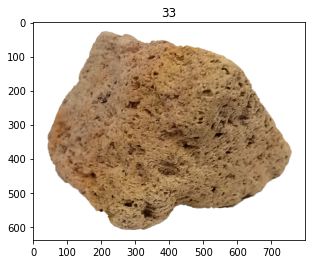

In [9]:
rock_id = 33
img = Image.open(rock_images[rock_id])
plt.imshow(img)
plt.title(rock_id);

## MDS coordinates

The following coordinates are displayed below:

* original coordinates by Sanders & Nosofsky (`MDS/mds_120_supplemental_dims.txt`)
* replicated coordinates with scikit-learn (derived from similarity judgements in `Similarity Judgments Data/rocks_similarity_120_*.txt`)

In [5]:
# original MDS coordinates for 120 Rocks Set
mds_obs = np.loadtxt(mds_file, skiprows=1)

print("Number of rocks:     ", np.shape(mds_obs)[0])
print("Number of dimensions:", np.shape(mds_obs)[1])

Number of rocks:      120
Number of dimensions: 13


In [6]:
# replicated MDS coordinates for 120 Rocks Set

seed = 3

# load judgements into 1 dataframe
df_jm = pd.read_csv(judgements_files[0], sep="\s+")
df_jm['Rater'] = int(judgements_files[0].split('_')[-1].replace('.txt', ''))

for jf in judgements_files:

    tmp = pd.read_csv(jf, sep="\s+")
    tmp['Rater'] = int(jf.split('_')[-1].replace('.txt', ''))
    df_jm = pd.concat([df_jm, tmp], sort=False).reset_index(drop=True)

df_jm = df_jm.sort_values(['Rater', 'Rock1Type', 'Rock2Type']).reset_index(drop=True)
df_jm['Rock1'] = df_jm['Rock1Type'].astype(str).str.pad(2,fillchar='0') + '_' + df_jm['Rock1Token'].astype(str).str.pad(2,fillchar='0')
df_jm['Rock2'] = df_jm['Rock2Type'].astype(str).str.pad(2,fillchar='0') + '_' + df_jm['Rock2Token'].astype(str).str.pad(2,fillchar='0')
df_jm = df_jm.drop(['Rock1Type', 'Rock2Type', 'Rock1Token', 'Rock2Token'], axis = 1)
df_jm = df_jm.reindex(columns=['Rater', 'Rock1', 'Rock2', 'Rating'])

# sorting pairs
df_jm[['Rock1', 'Rock2']] = np.sort(df_jm[['Rock1', 'Rock2']].values)

df_jm_grp = df_jm.groupby(['Rock1', 'Rock2']).mean().drop('Rater', axis=1).reset_index()

# make unique, sorted, common index
idx = sorted(set(df_jm_grp['Rock1']).union(df_jm_grp['Rock2']))

# reshape
df_dist = (df_jm_grp.pivot(index='Rock1', columns='Rock2', values='Rating')
    .reindex(index=idx, columns=idx)
    .fillna(0, downcast='infer')
    .pipe(lambda x: x+x.values.T))

# compute distances
m_dist = euclidean_distances(df_dist)
m_dist = manhattan_distances(df_dist)

#categories = [cat[:2] for cat in df_dist.index]

m = MDS(n_components=8, metric=True, dissimilarity='precomputed', random_state=seed)
# Get the embeddings
mds_repl = m.fit_transform(m_dist)

print("Number of rocks:     ", np.shape(mds_repl)[0])
print("Number of dimensions:", np.shape(mds_repl)[1])

Number of rocks:      120
Number of dimensions: 8


<div class="alert alert-warning">Note: Solution depends on the seed (random_state)</div>

### a) Dimensions 1 vs 2

(Lightness vs Grain size)

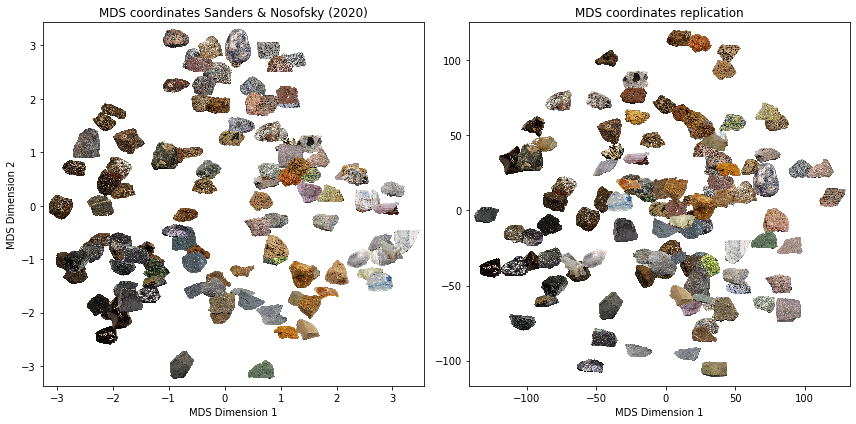

In [21]:
plot_compare_dims(1, 2, mds_obs, mds_repl, rock_images)

### b) Dimensions 3 vs 4

(Roughness vs Shininess)

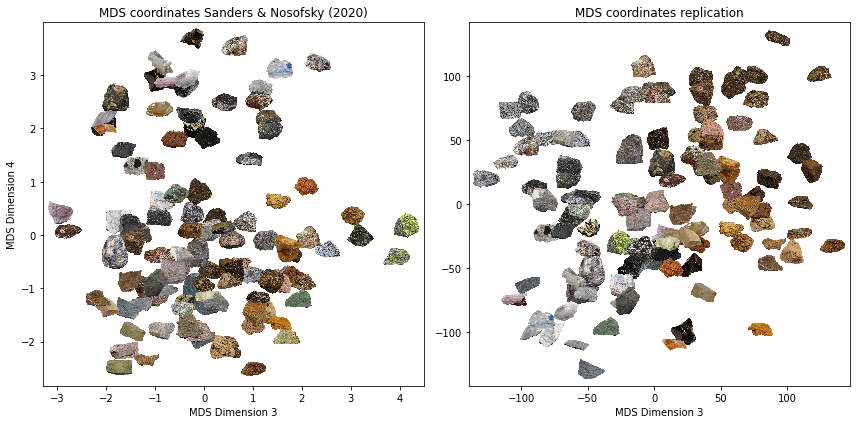

In [22]:
plot_compare_dims(3, 4, mds_obs, mds_repl, rock_images)

### c) Dimensions 5 vs 6

(Organizatoin vs Chromacity)

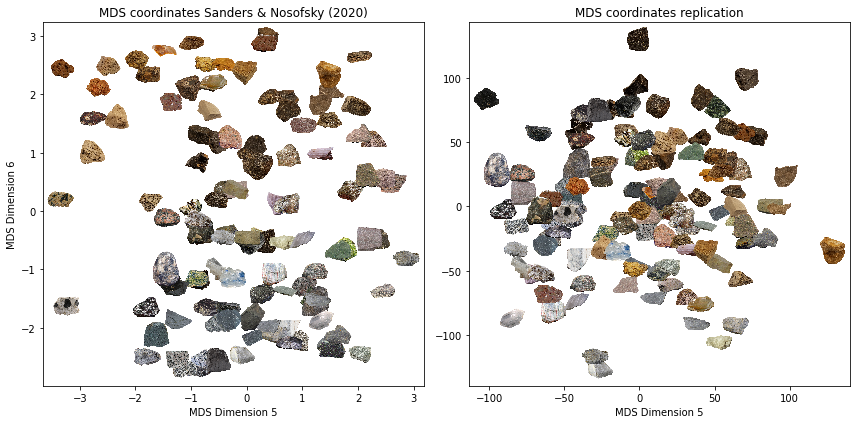

In [23]:
plot_compare_dims(5, 6, mds_obs, mds_repl, rock_images)

### d) Dimensions 7 vs 8

(Shape vs Hue)

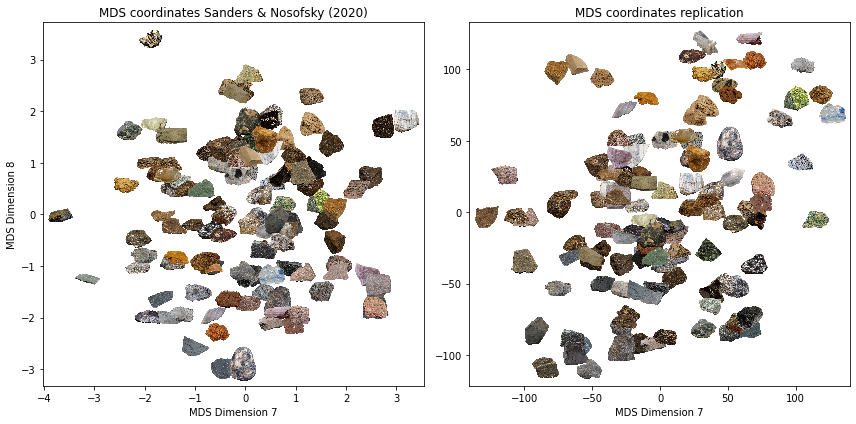

In [24]:
plot_compare_dims(7, 8, mds_obs, mds_repl, rock_images)

### e) Dimensions 8 vs 6

(Hue vs Chromacity)

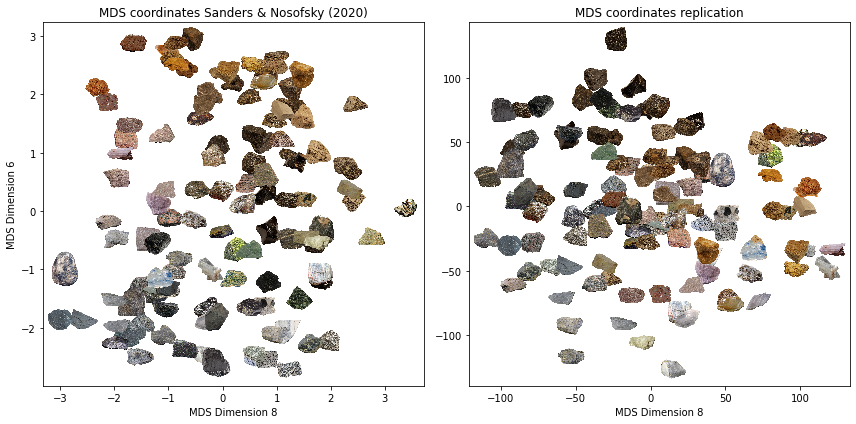

In [25]:
plot_compare_dims(8, 6, mds_obs, mds_repl, rock_images)

### Single dimension plots

<div class="alert alert-warning">Note: Only 6 dimensions plotted due to memory issues.</div>

Original MDS coordinates

In [ ]:
dims = range(1, 7)

plt.figure(figsize=(16, 16))

for dim in dims:

    for i, rock in enumerate(rock_images):
        imjitter(mds_obs[i, dim], dim, rock, zoom = 0.025)

plt.ylabel("Dimension")
plt.ylim(0, 10)
plt.yticks(dims);

Replicated MDS coordinates

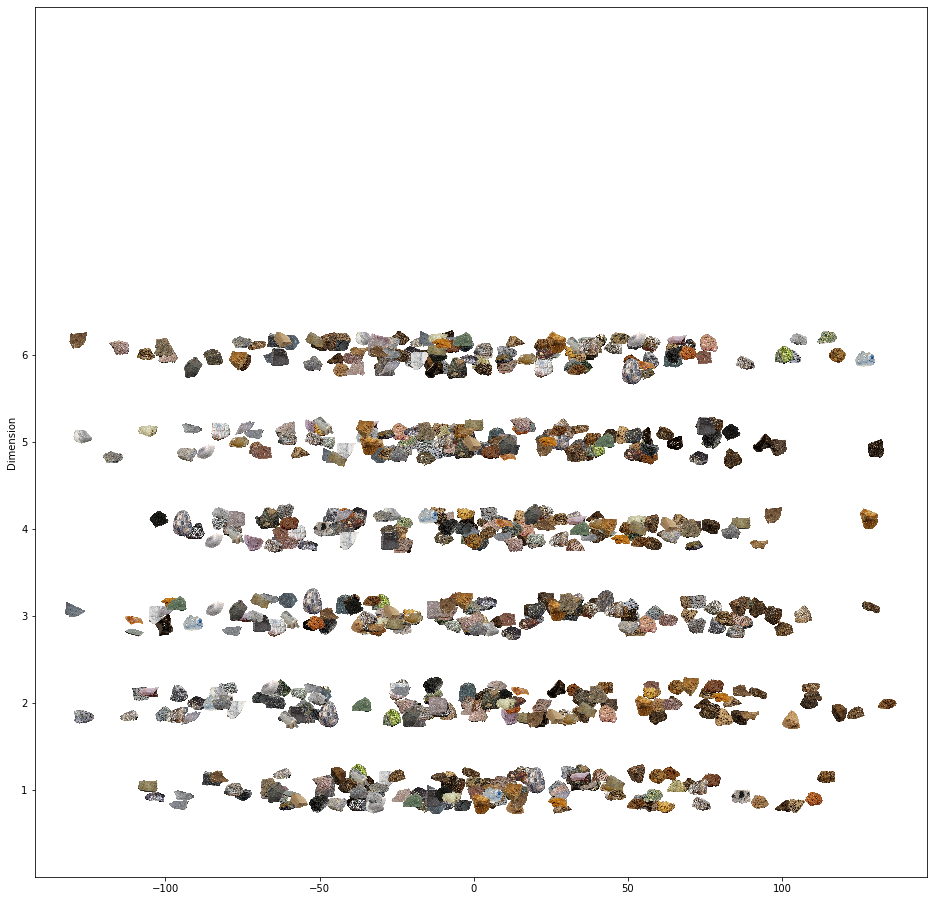

In [30]:
dims = range(1, 7)

plt.figure(figsize=(16, 16))

for dim in dims:

    for i, rock in enumerate(rock_images):
        imjitter(mds_repl[i, dim], dim, rock, zoom = 0.025)

plt.ylabel("Dimension")
plt.ylim(0, 10)
plt.yticks(dims);

## CNN predictions

The following predictions are displayed below:

* original predictions by Sanders & Nosofsky with their keras model (`CNN Predictions/MDS Dimensions/cnn_predicted_mds_120.txt`)
* replicated predictions with the same keras model (`CNN Predictions/MDS Dimensions/cnn_own_predicted_mds_120_?.txt`)
* replicated predictions with a new pytorch model (`CNN Predictions/MDS Dimensions/cnn_torch_predicted_mds_120.txt`)

In [6]:
cnn_pred_file = "CNN Predictions/MDS Dimensions/cnn_predicted_mds_120.txt"
cnn_pred = np.loadtxt(cnn_pred_file)

# 02.06.: cnn_own_predicted_mds_120_A.txt
cnn_own_pred_file = "CNN Predictions/MDS Dimensions/cnn_own_predicted_mds_120_A.txt"
cnn_own_pred = np.loadtxt(cnn_own_pred_file)

# 10.06.: cnn_own_predicted_mds_120_B.txt
cnn_own_pred_file_b = "CNN Predictions/MDS Dimensions/cnn_own_predicted_mds_120_B.txt"
cnn_own_pred_b = np.loadtxt(cnn_own_pred_file_b)

cnn_torch_pred_file = "CNN Predictions/MDS Dimensions/cnn_torch_predicted_mds_120.txt"
cnn_torch_pred = np.loadtxt(cnn_torch_pred_file)

score = r2_score(mds_obs[:, :8], cnn_pred)
score_own = r2_score(mds_obs[:, :8], cnn_own_pred)
score_own_b = r2_score(mds_obs[:, :8], cnn_own_pred_b)
score_torch = r2_score(mds_obs[:, :8], cnn_torch_pred)

print('R² scores overall')
print(f'sanders & nosofsky (2020):             {score: ,.2f}')
print(f'replication same keras model (02.06.): {score_own: ,.2f}')
print(f'replication same keras model (10.06.): {score_own_b: ,.2f}')
print(f'replication pytorch model:             {score_torch: ,.2f}')

R² scores overall
sanders & nosofsky (2020):             -0.20
replication same keras model (02.06.): -0.28
replication same keras model (10.06.): -0.36
replication pytorch model:             -0.09


In [7]:
dim = 1

score = r2_score(mds_obs[:, dim-1], cnn_pred[:, dim-1])
score_own = r2_score(mds_obs[:, dim-1], cnn_own_pred[:, dim-1])
score_own_b = r2_score(mds_obs[:, dim-1], cnn_own_pred_b[:, dim-1])
score_torch = r2_score(mds_obs[:, dim-1], cnn_torch_pred[:, dim-1])

print(f'R² scores dimension {dim}')
print(f'sanders & nosofsky (2020):             {score: ,.2f}')
print(f'replication same keras model (02.06.): {score_own: ,.2f}')
print(f'replication same keras model (10.06.): {score_own_b: ,.2f}')
print(f'replication pytorch model:             {score_torch: ,.2f}')

R² scores dimension 1
sanders & nosofsky (2020):              0.12
replication same keras model (02.06.):  0.19
replication same keras model (10.06.):  0.29
replication pytorch model:              0.22


<div class="alert-warning alert" role="alert">Note: Interpretation of R² scores still to be done.</div>

#### Lightness

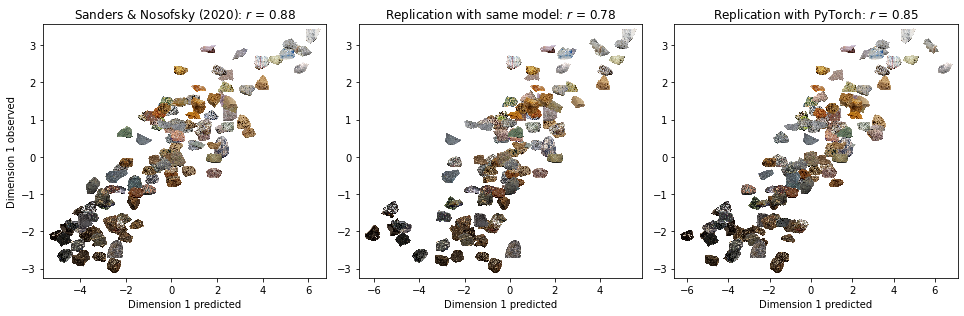

In [8]:
plot_compare_preds(1, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

#### Grain size

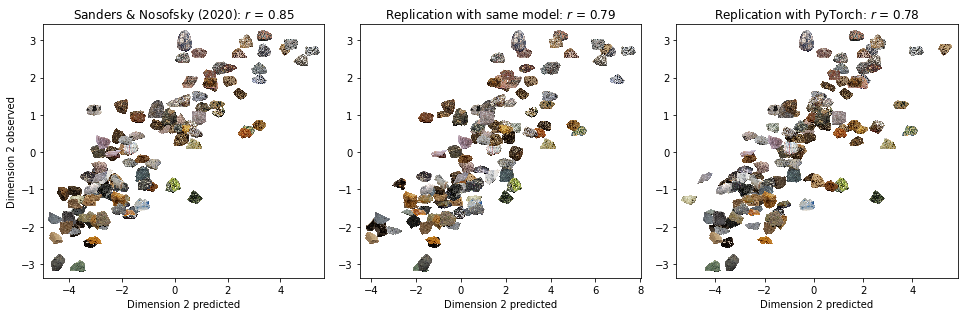

In [8]:
plot_compare_preds(2, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

#### Roughness

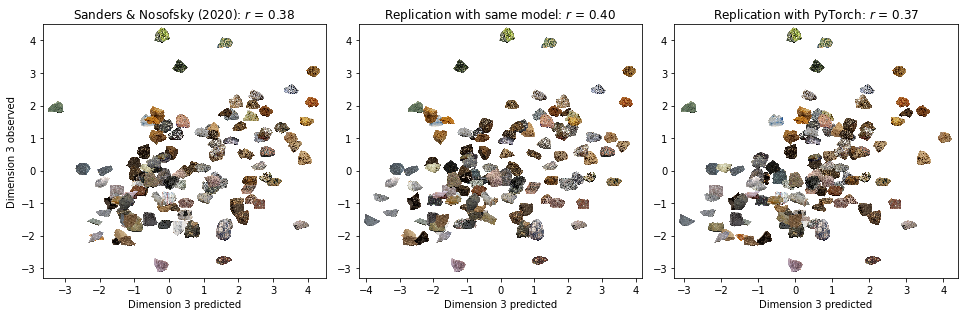

In [53]:
plot_compare_preds(3, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

#### Shininess

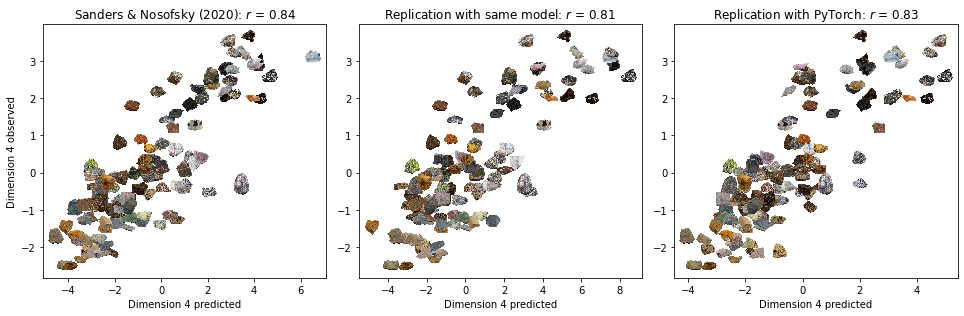

In [54]:
plot_compare_preds(4, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

#### Organization

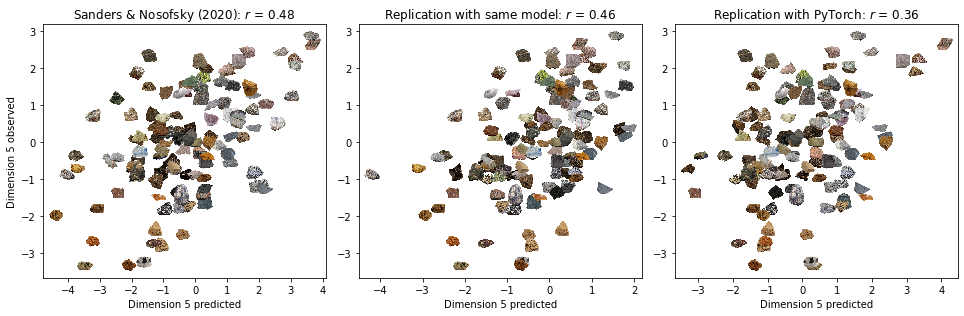

In [55]:
plot_compare_preds(5, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

#### Chromacity

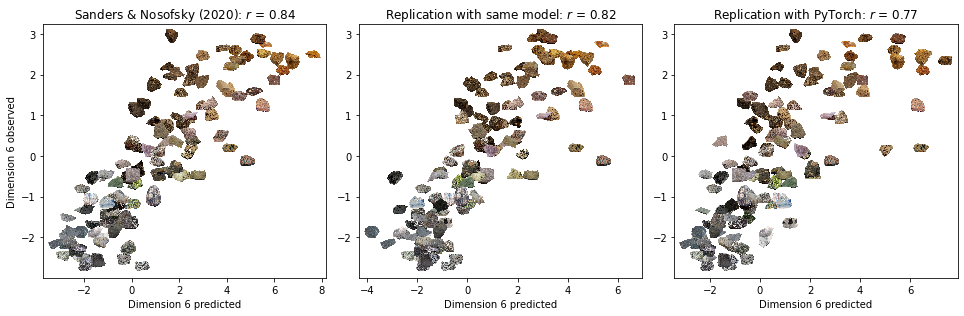

In [56]:
plot_compare_preds(6, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

#### Shape

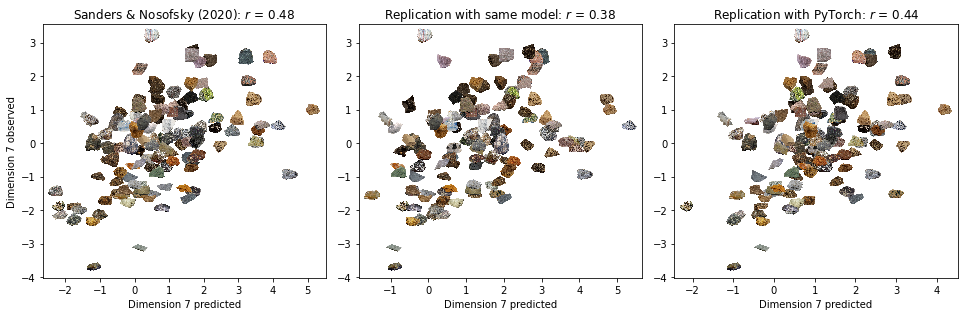

In [57]:
plot_compare_preds(7, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

#### Hue

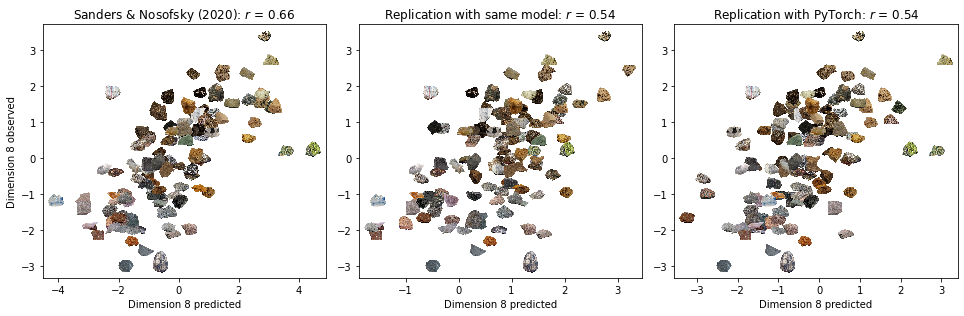

In [58]:
plot_compare_preds(8, mds_obs, cnn_pred, cnn_own_pred, cnn_torch_pred, "Sanders & Nosofsky (2020)", "Replication with same model", "Replication with PyTorch", rock_images)

<div class="alert alert-success" role="alert">Running the authors Keras-model we are getting similar results, yet the correlations are still not as high. Same applies to our newly built PyTorch model.</div>

### Plausibility check for 360 Rocks Training Dataset

... just to see if the mds coordinates data fits the images in the folder.

In [38]:
import pandas as pd

path_to_360 = "../sanders_2018/360 Rocks/"
df_360 = pd.read_csv("../finetuning_torchvision_data/mds_360.csv")
rock_images_360 = list(path_to_360 + df_360.image_name)
mds_obs_360 = df_360.iloc[:, 1:].values

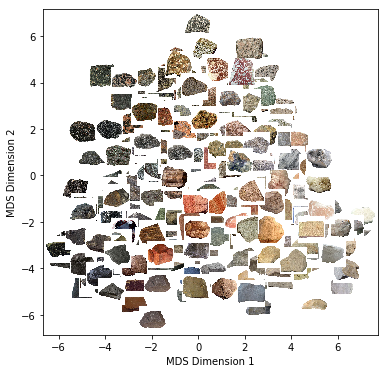

In [39]:
plot_dims(1, 2, mds_obs_360, rock_images_360)

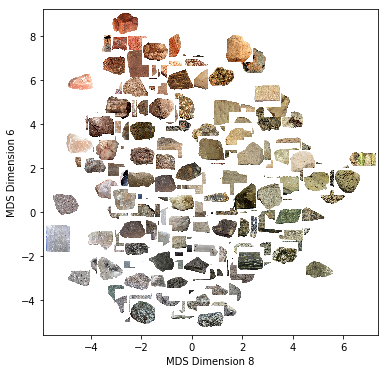

In [41]:
plot_dims(8, 6, mds_obs_360, rock_images_360)